In [1]:
import copy
import gc
import os

import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm_notebook

import netCDF4
import seaborn as sns
import xarray as xr


print(os.listdir("../input/"))

['land-cover', 'merra1', '201015-ca-population-density', 'merra1c']


In [2]:
print(os.listdir("../input/land-cover/"))

['ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-USER_REGION-v2.0.7.nc']


In [3]:
# functions / classes

# split date to its parts
def get_date(df, col, delim="-", drop=False):
    df[["year", "month", "day"]] = df[col].str.split(delim, expand=True).astype(int)
    df["day_of_year"] = pd.to_datetime(
        df[col], format="%Y-%m-%d", exact=True
    ).dt.dayofyear
    df["week"] = pd.to_datetime(df[col], format="%Y-%m-%d", exact=True).dt.week
    if drop:
        df.drop(col, inplace=True)
    return df


# plot grid data with heatmap
def map_with_heatmap(
    df, value, lat_column, lon_column, annot=False, cmap="tab20b", aggfunc=np.sum
):
    map_df = df.pivot_table(
        index=lat_column, columns=lon_column, values=value, aggfunc=aggfunc
    )
    f, ax = plt.subplots(figsize=(9, 9))
    sns.heatmap(
        map_df, annot=annot, cmap=cmap, annot_kws={"fontsize": 8}, linewidths=0.0, ax=ax
    )
    ax.invert_yaxis()

In [4]:
d3 = pd.read_csv("../input/merra1/full_dataset3.csv")
d3.shape

(357, 9)

In [5]:
# calculate average hight of cell from surface geopotential height (PHIS)
g = 9.807
d3["elevation"] = d3["PHIS"] / g
d3.tail()

,FRLAND,PHIS,SGH,FRLANDICE,FROCEAN,FRLAKE,lat,lon,time,elevation
352,1.000000,17165.580078,119.394272,0.0,0.0,0.000000,42.0,-116.250,1992-01-02 03:00:00,1750.339561
353,0.993407,17976.187500,150.184280,0.0,0.0,0.006593,42.0,-115.625,1992-01-02 03:00:00,1832.995564
354,1.000000,18244.773438,157.813309,0.0,0.0,0.000000,42.0,-115.000,1992-01-02 03:00:00,1860.382730
355,1.000000,17322.228516,160.704834,0.0,0.0,0.000000,42.0,-114.375,1992-01-02 03:00:00,1766.312686
356,1.000000,17435.363281,201.050461,0.0,0.0,0.000000,42.0,-113.750,1992-01-02 03:00:00,1777.848810


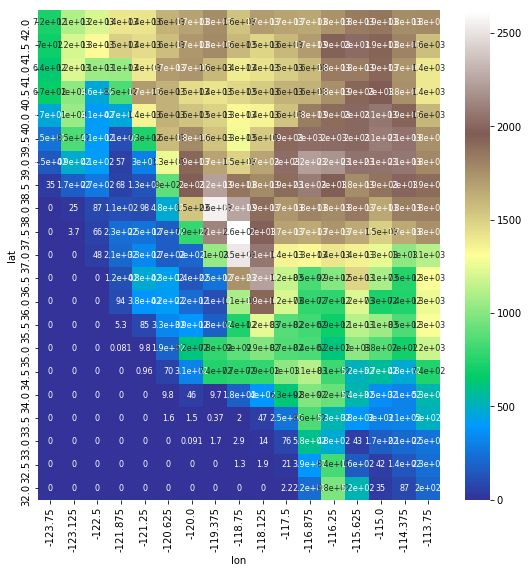

In [6]:
# show average elevation
map_with_heatmap(
    d3,
    value="elevation",
    lat_column="lat",
    lon_column="lon",
    annot=True,
    aggfunc=np.mean,
    cmap="terrain",
)

In [7]:
class SubGridBuilder:
    """
    Builds grid based on west, east, north, south edge, grid steps.
    Builds subgrid as well. Divider determines the subgrid steps: 1: original grid, 2: 1/2 step, 3: 1/3 step
    init Parameters:
        grid_WESN: tuple of the coordinates of the outmost base gridpoints, e.g. (-125, -113.75, 32.5, 42) 
        grid_gaps: tuple of south-north and east-west steps e.g (1,1) means 1 degree steps
        divider (int): the subgrid step divider
    instance parameters:
        west, east, south, north: the outmost gridpoints of the base grid
        gap_lon, gap_lat: the base grid steps
        default_lon_grid, default_lat_grid: the lon and lat coordinate list of the base grids
        default_lon_border, default_lat_border: the base grid borders
        sub_ . . . : same as above for the subgrid 
    """

    def __init__(self, grid_WESN, grid_gaps=(1, 1), divider=1):
        self.divider = int(divider)
        self.west = grid_WESN[0]
        self.east = grid_WESN[1]
        self.south = grid_WESN[2]
        self.north = grid_WESN[3]
        self.gap_lon = grid_gaps[0]
        self.gap_lat = grid_gaps[1]
        self.default_lon_grid = [
            x for x in np.arange(self.west, self.east + self.gap_lon, self.gap_lon)
        ]
        self.default_lat_grid = [
            x for x in np.arange(self.south, self.north + self.gap_lat, self.gap_lat)
        ]
        self.default_lon_border = [
            x
            for x in np.arange(
                self.west - (self.gap_lon / 2),
                self.east + (self.gap_lon / 2) + self.gap_lon,
                self.gap_lon,
            )
        ]
        self.default_lat_border = [
            x
            for x in np.arange(
                self.south - (self.gap_lat / 2),
                self.north + (self.gap_lat / 2) + self.gap_lat,
                self.gap_lat,
            )
        ]
        self.sub_lon_grid, self.sub_lon_border, self.sub_lat_grid, self.sub_lat_border = (
            self.build_grid()
        )

    def build_grid(self):
        """
        Builds the subgrid gridpoints and borders
        returns the subgrid geometry
        """
        if self.divider < 1:
            raise ValueError("divider should be integer and larger than 0")
        if self.divider == 1:
            return (
                self.default_lon_grid,
                self.default_lon_border,
                self.default_lat_grid,
                self.default_lat_border,
            )
        else:
            lon_border = np.linspace(
                self.default_lon_border[0],
                self.default_lon_border[-1],
                (len(self.default_lon_grid) * self.divider) + 1,
            )
            lat_border = np.linspace(
                self.default_lat_border[0],
                self.default_lat_border[-1],
                (len(self.default_lat_grid) * self.divider) + 1,
            )
            lon_grid = [
                (lon_border[i] + lon_border[i + 1]) / 2
                for i, x in enumerate(lon_border)
                if i < len(lon_border) - 1
            ]
            lat_grid = [
                (lat_border[i] + lat_border[i + 1]) / 2
                for i, x in enumerate(lat_border)
                if i < len(lat_border) - 1
            ]
            return (lon_grid, lon_border.tolist(), lat_grid, lat_border.tolist())


class LandCoverGridder:
    """
    Converts the land cover nc file to pandas dataframe
    docs of land cover data: http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-Ph2-PUGv2_2.0.pdf
    """

    def __init__(self, grid, nc_file):
        self.grid = grid
        self.nc_file = nc_file
        self.existing_land_types = ["no data, build the grid!"]

    def build_full_dataframe(self):
        """
        builds the dataframe with the original level of resolution
        """
        ds = xr.open_mfdataset(self.nc_file)
        df = ds.to_dataframe()
        df.reset_index(inplace=True)
        df = df[["lat", "lon", "lccs_class"]]
        df["lccs_class"] = df["lccs_class"].astype(int)
        self.existing_land_types = df["lccs_class"].unique()
        return df

    def merge_to_main_cats(self, dfr, catIsNumeric):
        """
        merges the dataframe with the more detailed land cover types
        to the more general land cover types
        if catIsNumeric = False the features are string, else numbers
        """
        main_land_types = {
            "agriculture": 1,
            "forest": 2,
            "grassland": 3,
            "wetland": 4,
            "settlement": 5,
            "shrubland": 6,
            "sparse_veg": 7,
            "bare_area": 8,
            "water": 9,
        }
        main_land_types_groups = {
            "agriculture": [10, 11, 12, 20, 30, 40],
            "forest": [50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90, 100, 160, 170],
            "grassland": [110, 130],
            "wetland": [180],
            "settlement": [190],
            "shrubland": [120, 121, 122],
            "sparse_veg": [140, 150, 151, 152, 153],
            "bare_area": [200, 201, 202],
            "water": [210],
        }
        # don't change the existing object
        df = copy.deepcopy(dfr)
        main_land_types_existing = {}
        for cat, catlist in main_land_types_groups.items():
            catlist = set(catlist).intersection(set(self.existing_land_types))
            main_land_types_existing.update({cat: list(catlist)})
        for category in main_land_types_groups:
            df[category] = df[main_land_types_existing[category]].sum(axis=1)
        df = df.drop(list(self.existing_land_types), axis=1)
        df["max_type_freq"] = df[list(main_land_types.keys())].max(axis=1)
        df["max_type"] = df[list(main_land_types.keys())].idxmax(axis=1)
        if catIsNumeric == True:
            df = df.replace(main_land_types)
        return df

    def __to_grid(self, lat_border, lon_border, isDetailed):
        """
        private, use to_default_grid or to_sub_grid instead
        converts the full dataframe to the base grid or the sub grid
        """
        df = self.build_full_dataframe()
        df["lccs_class"] = df["lccs_class"].astype(int)
        df["lat_borders"] = pd.cut(df["lat"], lat_border)
        df["lon_borders"] = pd.cut(df["lon"], lon_border)
        df = df.dropna()
        groups = df.groupby(["lat_borders", "lon_borders"])
        df = groups["lccs_class"].value_counts().unstack().fillna(0)
        df.reset_index(inplace=True)
        df["lat_grid"] = df["lat_borders"].apply(lambda x: x.mid)
        df["lon_grid"] = df["lon_borders"].apply(lambda x: x.mid)
        df["count"] = df[self.existing_land_types].sum(axis=1)
        df[self.existing_land_types] = df[self.existing_land_types].apply(
            lambda x: x / df["count"]
        )
        df["max_type_freq"] = df[self.existing_land_types].max(axis=1)
        df["max_type"] = df[self.existing_land_types].idxmax(axis=1)
        if isDetailed == False:
            df = self.merge_to_main_cats(df, False)
        return df

    def to_default_grid(self, isDetailed):
        """
        converts the full dataframe to the base grid
        if isDetailed = True it returns all the land cover types, else it returns the more general categories
        """
        return self.__to_grid(
            self.grid.default_lat_border, self.grid.default_lon_border, isDetailed
        )

    def to_sub_grid(self, isDetailed):
        """
        converts the full dataframe to the sub grid
        if isDetailed = True it returns all the land cover types, else it returns the more general categories
        """
        return self.__to_grid(
            self.grid.sub_lat_border, self.grid.sub_lon_border, isDetailed
        )

In [8]:
# first we determine our geo-grid and subgrid this object will hold these geoinformations
gridparams = SubGridBuilder((-123.75, -113.75, 32, 42), (0.625, 0.5), 3)

In [9]:
# with the gridparams and the file we instantiate a LandCoverGridder
lcgr = LandCoverGridder(
    gridparams,
    "../input/land-cover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-USER_REGION-v2.0.7.nc",
)

In [10]:
# and calculate the grid: default, sub or both
df_def = lcgr.to_default_grid(isDetailed=True)
df_def.tail()

lccs_class,lat_borders,lon_borders,10,11,30,40,60,70,80,90,100,110,120,130,150,160,180,190,200,210,220,lat_grid,lon_grid,count,max_type_freq,max_type
352,"(41.75, 42.25]","(-116.562, -115.938]",0.005531,0.014568,0.000642,0.001654,0.060963,0.019951,0.007037,0.000000,0.000074,0.000000,0.864000,0.002593,0.000000,0.017185,0.000963,0.000000,0.000395,0.004444,0.0,42.0,-116.250,40500.0,0.864000,120
353,"(41.75, 42.25]","(-115.938, -115.312]",0.002889,0.000123,0.000173,0.000173,0.022198,0.062889,0.000691,0.000099,0.000000,0.000000,0.908049,0.001728,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,0.0,42.0,-115.625,40500.0,0.908049,120
354,"(41.75, 42.25]","(-115.312, -114.688]",0.000938,0.001136,0.000025,0.000716,0.001333,0.019605,0.003062,0.000000,0.000025,0.000000,0.960000,0.005877,0.000000,0.002543,0.000000,0.000000,0.000000,0.004741,0.0,42.0,-115.000,40500.0,0.960000,120
355,"(41.75, 42.25]","(-114.688, -114.062]",0.000988,0.005210,0.000346,0.000346,0.023160,0.114395,0.000321,0.000000,0.000000,0.000222,0.836148,0.015802,0.000000,0.003037,0.000000,0.000025,0.000000,0.000000,0.0,42.0,-114.375,40500.0,0.836148,120
356,"(41.75, 42.25]","(-114.062, -113.438]",0.005580,0.024370,0.006420,0.002864,0.006716,0.304889,0.000049,0.000000,0.000000,0.000198,0.566049,0.076691,0.000049,0.004025,0.000000,0.000000,0.000494,0.001605,0.0,42.0,-113.750,40500.0,0.566049,120


In [11]:
df_def.shape

(357, 26)

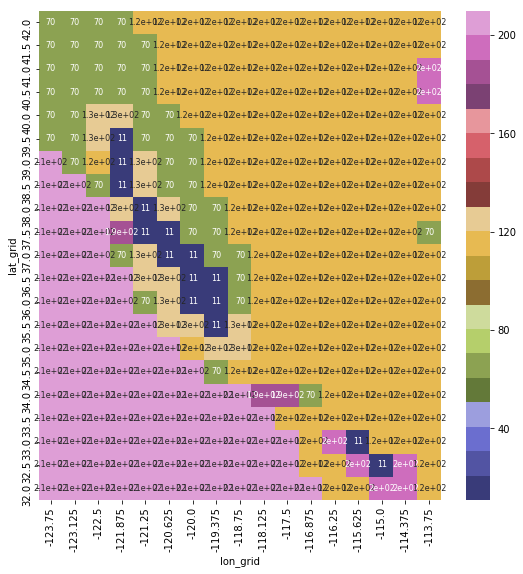

In [12]:
map_with_heatmap(
    df_def,
    value="max_type",
    lat_column="lat_grid",
    lon_column="lon_grid",
    annot=True,
    aggfunc=np.max,
)

In [13]:
df_def_mergedcats = lcgr.merge_to_main_cats(df_def, catIsNumeric=False)
df_def_mergedcats.shape

(357, 16)

In [14]:
df_allcat = pd.merge(
    df_def,
    df_def_mergedcats,
    on=["lat_grid", "lon_grid"],
    how="inner",
    suffixes=("_detailed", "_merged"),
)

In [15]:
df_allcat.tail()

lccs_class,lat_borders_detailed,lon_borders_detailed,10,11,30,40,60,70,80,90,100,110,120,130,150,160,180,190,200,210,220,lat_grid,lon_grid,count_detailed,max_type_freq_detailed,max_type_detailed,lat_borders_merged,lon_borders_merged,count_merged,max_type_freq_merged,max_type_merged,agriculture,forest,grassland,wetland,settlement,shrubland,sparse_veg,bare_area,water
352,"(41.75, 42.25]","(-116.562, -115.938]",0.005531,0.014568,0.000642,0.001654,0.060963,0.019951,0.007037,0.000000,0.000074,0.000000,0.864000,0.002593,0.000000,0.017185,0.000963,0.000000,0.000395,0.004444,0.0,42.0,-116.250,40500.0,0.864000,120,"(41.75, 42.25]","(-116.562, -115.938]",40500.0,0.864000,shrubland,0.022395,0.105210,0.002593,0.000963,0.000000,0.864000,0.000000,0.000395,0.004444
353,"(41.75, 42.25]","(-115.938, -115.312]",0.002889,0.000123,0.000173,0.000173,0.022198,0.062889,0.000691,0.000099,0.000000,0.000000,0.908049,0.001728,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,0.0,42.0,-115.625,40500.0,0.908049,120,"(41.75, 42.25]","(-115.938, -115.312]",40500.0,0.908049,shrubland,0.003358,0.086864,0.001728,0.000000,0.000000,0.908049,0.000000,0.000000,0.000000
354,"(41.75, 42.25]","(-115.312, -114.688]",0.000938,0.001136,0.000025,0.000716,0.001333,0.019605,0.003062,0.000000,0.000025,0.000000,0.960000,0.005877,0.000000,0.002543,0.000000,0.000000,0.000000,0.004741,0.0,42.0,-115.000,40500.0,0.960000,120,"(41.75, 42.25]","(-115.312, -114.688]",40500.0,0.960000,shrubland,0.002815,0.026568,0.005877,0.000000,0.000000,0.960000,0.000000,0.000000,0.004741
355,"(41.75, 42.25]","(-114.688, -114.062]",0.000988,0.005210,0.000346,0.000346,0.023160,0.114395,0.000321,0.000000,0.000000,0.000222,0.836148,0.015802,0.000000,0.003037,0.000000,0.000025,0.000000,0.000000,0.0,42.0,-114.375,40500.0,0.836148,120,"(41.75, 42.25]","(-114.688, -114.062]",40500.0,0.836148,shrubland,0.006889,0.140914,0.016025,0.000000,0.000025,0.836148,0.000000,0.000000,0.000000
356,"(41.75, 42.25]","(-114.062, -113.438]",0.005580,0.024370,0.006420,0.002864,0.006716,0.304889,0.000049,0.000000,0.000000,0.000198,0.566049,0.076691,0.000049,0.004025,0.000000,0.000000,0.000494,0.001605,0.0,42.0,-113.750,40500.0,0.566049,120,"(41.75, 42.25]","(-114.062, -113.438]",40500.0,0.566049,shrubland,0.039235,0.315679,0.076889,0.000000,0.000000,0.566049,0.000049,0.000494,0.001605


In [16]:
df_allcat = df_allcat.drop(
    ["lat_borders_merged", "lon_borders_merged", "count_merged", "count_detailed"],
    axis=1,
)

In [17]:
df_allcat["lat_grid"] = df_allcat["lat_grid"].astype("float")
df_allcat["lon_grid"] = df_allcat["lon_grid"].astype("float")
df_allcat.tail()

lccs_class,lat_borders_detailed,lon_borders_detailed,10,11,30,40,60,70,80,90,100,110,120,130,150,160,180,190,200,210,220,lat_grid,lon_grid,max_type_freq_detailed,max_type_detailed,max_type_freq_merged,max_type_merged,agriculture,forest,grassland,wetland,settlement,shrubland,sparse_veg,bare_area,water
352,"(41.75, 42.25]","(-116.562, -115.938]",0.005531,0.014568,0.000642,0.001654,0.060963,0.019951,0.007037,0.000000,0.000074,0.000000,0.864000,0.002593,0.000000,0.017185,0.000963,0.000000,0.000395,0.004444,0.0,42.0,-116.250,0.864000,120,0.864000,shrubland,0.022395,0.105210,0.002593,0.000963,0.000000,0.864000,0.000000,0.000395,0.004444
353,"(41.75, 42.25]","(-115.938, -115.312]",0.002889,0.000123,0.000173,0.000173,0.022198,0.062889,0.000691,0.000099,0.000000,0.000000,0.908049,0.001728,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,0.0,42.0,-115.625,0.908049,120,0.908049,shrubland,0.003358,0.086864,0.001728,0.000000,0.000000,0.908049,0.000000,0.000000,0.000000
354,"(41.75, 42.25]","(-115.312, -114.688]",0.000938,0.001136,0.000025,0.000716,0.001333,0.019605,0.003062,0.000000,0.000025,0.000000,0.960000,0.005877,0.000000,0.002543,0.000000,0.000000,0.000000,0.004741,0.0,42.0,-115.000,0.960000,120,0.960000,shrubland,0.002815,0.026568,0.005877,0.000000,0.000000,0.960000,0.000000,0.000000,0.004741
355,"(41.75, 42.25]","(-114.688, -114.062]",0.000988,0.005210,0.000346,0.000346,0.023160,0.114395,0.000321,0.000000,0.000000,0.000222,0.836148,0.015802,0.000000,0.003037,0.000000,0.000025,0.000000,0.000000,0.0,42.0,-114.375,0.836148,120,0.836148,shrubland,0.006889,0.140914,0.016025,0.000000,0.000025,0.836148,0.000000,0.000000,0.000000
356,"(41.75, 42.25]","(-114.062, -113.438]",0.005580,0.024370,0.006420,0.002864,0.006716,0.304889,0.000049,0.000000,0.000000,0.000198,0.566049,0.076691,0.000049,0.004025,0.000000,0.000000,0.000494,0.001605,0.0,42.0,-113.750,0.566049,120,0.566049,shrubland,0.039235,0.315679,0.076889,0.000000,0.000000,0.566049,0.000049,0.000494,0.001605


In [18]:
df_all = pd.merge(
    d3,
    df_allcat,
    left_on=["lat", "lon"],
    right_on=["lat_grid", "lon_grid"],
    how="inner",
)

In [19]:
df_all = df_all.drop(["time", "lat_grid", "lon_grid"], axis=1)

In [20]:
df_all.tail()

,FRLAND,PHIS,SGH,FRLANDICE,FROCEAN,FRLAKE,lat,lon,elevation,lat_borders_detailed,lon_borders_detailed,10,11,30,40,60,70,80,90,100,110,120,130,150,160,180,190,200,210,220,max_type_freq_detailed,max_type_detailed,max_type_freq_merged,max_type_merged,agriculture,forest,grassland,wetland,settlement,shrubland,sparse_veg,bare_area,water
352,1.000000,17165.580078,119.394272,0.0,0.0,0.000000,42.0,-116.250,1750.339561,"(41.75, 42.25]","(-116.562, -115.938]",0.005531,0.014568,0.000642,0.001654,0.060963,0.019951,0.007037,0.000000,0.000074,0.000000,0.864000,0.002593,0.000000,0.017185,0.000963,0.000000,0.000395,0.004444,0.0,0.864000,120,0.864000,shrubland,0.022395,0.105210,0.002593,0.000963,0.000000,0.864000,0.000000,0.000395,0.004444
353,0.993407,17976.187500,150.184280,0.0,0.0,0.006593,42.0,-115.625,1832.995564,"(41.75, 42.25]","(-115.938, -115.312]",0.002889,0.000123,0.000173,0.000173,0.022198,0.062889,0.000691,0.000099,0.000000,0.000000,0.908049,0.001728,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,0.0,0.908049,120,0.908049,shrubland,0.003358,0.086864,0.001728,0.000000,0.000000,0.908049,0.000000,0.000000,0.000000
354,1.000000,18244.773438,157.813309,0.0,0.0,0.000000,42.0,-115.000,1860.382730,"(41.75, 42.25]","(-115.312, -114.688]",0.000938,0.001136,0.000025,0.000716,0.001333,0.019605,0.003062,0.000000,0.000025,0.000000,0.960000,0.005877,0.000000,0.002543,0.000000,0.000000,0.000000,0.004741,0.0,0.960000,120,0.960000,shrubland,0.002815,0.026568,0.005877,0.000000,0.000000,0.960000,0.000000,0.000000,0.004741
355,1.000000,17322.228516,160.704834,0.0,0.0,0.000000,42.0,-114.375,1766.312686,"(41.75, 42.25]","(-114.688, -114.062]",0.000988,0.005210,0.000346,0.000346,0.023160,0.114395,0.000321,0.000000,0.000000,0.000222,0.836148,0.015802,0.000000,0.003037,0.000000,0.000025,0.000000,0.000000,0.0,0.836148,120,0.836148,shrubland,0.006889,0.140914,0.016025,0.000000,0.000025,0.836148,0.000000,0.000000,0.000000
356,1.000000,17435.363281,201.050461,0.0,0.0,0.000000,42.0,-113.750,1777.848810,"(41.75, 42.25]","(-114.062, -113.438]",0.005580,0.024370,0.006420,0.002864,0.006716,0.304889,0.000049,0.000000,0.000000,0.000198,0.566049,0.076691,0.000049,0.004025,0.000000,0.000000,0.000494,0.001605,0.0,0.566049,120,0.566049,shrubland,0.039235,0.315679,0.076889,0.000000,0.000000,0.566049,0.000049,0.000494,0.001605


In [21]:
pdf_2015 = pd.read_csv(
    "../input/201015-ca-population-density/2015_population_density_CA.csv"
)

In [22]:
def to_grid(df, lat_border, lon_border, to_drop):
    df["lat_borders"] = pd.cut(df["latitude"], lat_border)
    df["lon_borders"] = pd.cut(df["longitude"], lon_border)
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    cols = [x for x in df.columns if x not in to_drop]
    df = (
        df[cols]
        .groupby(["lat_borders", "lon_borders"])
        .apply(lambda x: x.reset_index(drop=True))
    )
    df.reset_index(drop=True, inplace=True)
    df["lat_grid"] = df["lat_borders"].apply(lambda x: x.mid)
    df["lon_grid"] = df["lon_borders"].apply(lambda x: x.mid)
    df.drop(["lat_borders", "lon_borders"], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [23]:
# we don't need the original coordinates, only the grid coordinates for aggregation
to_drop = ["latitude", "longitude"]
df_2015 = to_grid(
    pdf_2015, gridparams.default_lat_border, gridparams.default_lon_border, to_drop
)

In [24]:
df_2015.head()

,population density,lat_grid,lon_grid
0,-9999.0,32.0,-123.75
1,-9999.0,32.0,-123.75
2,-9999.0,32.0,-123.75
3,-9999.0,32.0,-123.75
4,-9999.0,32.0,-123.75


In [25]:
# original ocean grids are -9999.0, this makes very bad estimations on shores
df_2015.loc[df_2015["population density"] == -9999.0, "population density"] = 0

In [26]:
df_2015.head()

,population density,lat_grid,lon_grid
0,0.0,32.0,-123.75
1,0.0,32.0,-123.75
2,0.0,32.0,-123.75
3,0.0,32.0,-123.75
4,0.0,32.0,-123.75


In [27]:
# aggregate with mean, because this is density
df_2015 = df_2015.groupby(["lat_grid", "lon_grid"]).mean()

In [28]:
df_2015.reset_index(inplace=True)
df_2015

,lat_grid,lon_grid,population density
0,32.0,-123.750,0.000000
1,32.0,-123.125,0.000000
2,32.0,-122.500,0.000000
3,32.0,-121.875,0.000000
4,32.0,-121.250,0.000000
5,32.0,-120.625,0.000000
6,32.0,-120.000,0.000000
7,32.0,-119.375,0.000000
8,32.0,-118.750,0.000000
9,32.0,-118.125,0.000000


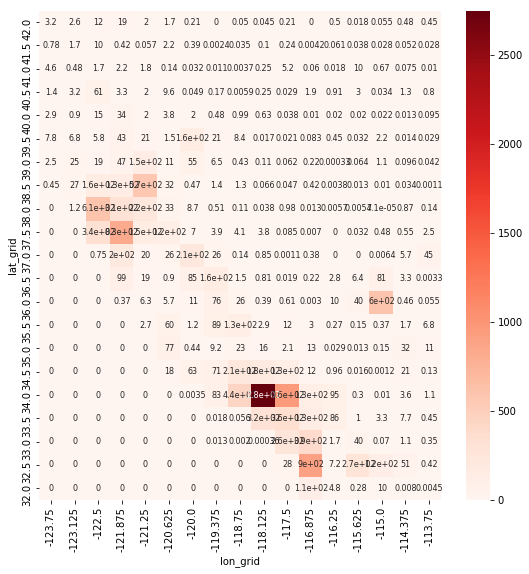

In [29]:
map_with_heatmap(
    df_2015,
    value="population density",
    lat_column="lat_grid",
    lon_column="lon_grid",
    annot=True,
    aggfunc=np.mean,
    cmap="Reds",
)

In [30]:
df_2015.dtypes

lat_grid              category
lon_grid              category
population density     float64
dtype: object

In [31]:
df_2015["lat_grid"] = df_2015["lat_grid"].astype("float")
df_2015["lon_grid"] = df_2015["lon_grid"].astype("float")

In [32]:
df_all = pd.merge(
    df_2015,
    df_all,
    left_on=["lat_grid", "lon_grid"],
    right_on=["lat", "lon"],
    how="inner",
)

In [33]:
df_all = df_all.drop(["lat_grid", "lon_grid"], axis=1)

In [34]:
df_all.tail()

,population density,FRLAND,PHIS,SGH,FRLANDICE,FROCEAN,FRLAKE,lat,lon,elevation,lat_borders_detailed,lon_borders_detailed,10,11,30,40,60,70,80,90,100,110,120,130,150,160,180,190,200,210,220,max_type_freq_detailed,max_type_detailed,max_type_freq_merged,max_type_merged,agriculture,forest,grassland,wetland,settlement,shrubland,sparse_veg,bare_area,water
352,0.497670,1.000000,17165.580078,119.394272,0.0,0.0,0.000000,42.0,-116.250,1750.339561,"(41.75, 42.25]","(-116.562, -115.938]",0.005531,0.014568,0.000642,0.001654,0.060963,0.019951,0.007037,0.000000,0.000074,0.000000,0.864000,0.002593,0.000000,0.017185,0.000963,0.000000,0.000395,0.004444,0.0,0.864000,120,0.864000,shrubland,0.022395,0.105210,0.002593,0.000963,0.000000,0.864000,0.000000,0.000395,0.004444
353,0.018293,0.993407,17976.187500,150.184280,0.0,0.0,0.006593,42.0,-115.625,1832.995564,"(41.75, 42.25]","(-115.938, -115.312]",0.002889,0.000123,0.000173,0.000173,0.022198,0.062889,0.000691,0.000099,0.000000,0.000000,0.908049,0.001728,0.000000,0.000988,0.000000,0.000000,0.000000,0.000000,0.0,0.908049,120,0.908049,shrubland,0.003358,0.086864,0.001728,0.000000,0.000000,0.908049,0.000000,0.000000,0.000000
354,0.055071,1.000000,18244.773438,157.813309,0.0,0.0,0.000000,42.0,-115.000,1860.382730,"(41.75, 42.25]","(-115.312, -114.688]",0.000938,0.001136,0.000025,0.000716,0.001333,0.019605,0.003062,0.000000,0.000025,0.000000,0.960000,0.005877,0.000000,0.002543,0.000000,0.000000,0.000000,0.004741,0.0,0.960000,120,0.960000,shrubland,0.002815,0.026568,0.005877,0.000000,0.000000,0.960000,0.000000,0.000000,0.004741
355,0.479826,1.000000,17322.228516,160.704834,0.0,0.0,0.000000,42.0,-114.375,1766.312686,"(41.75, 42.25]","(-114.688, -114.062]",0.000988,0.005210,0.000346,0.000346,0.023160,0.114395,0.000321,0.000000,0.000000,0.000222,0.836148,0.015802,0.000000,0.003037,0.000000,0.000025,0.000000,0.000000,0.0,0.836148,120,0.836148,shrubland,0.006889,0.140914,0.016025,0.000000,0.000025,0.836148,0.000000,0.000000,0.000000
356,0.446066,1.000000,17435.363281,201.050461,0.0,0.0,0.000000,42.0,-113.750,1777.848810,"(41.75, 42.25]","(-114.062, -113.438]",0.005580,0.024370,0.006420,0.002864,0.006716,0.304889,0.000049,0.000000,0.000000,0.000198,0.566049,0.076691,0.000049,0.004025,0.000000,0.000000,0.000494,0.001605,0.0,0.566049,120,0.566049,shrubland,0.039235,0.315679,0.076889,0.000000,0.000000,0.566049,0.000049,0.000494,0.001605


In [35]:
df_all.to_csv("constants_basegrid_divider_1.csv", index=False)